In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt

# Часть 1

In [ ]:
# Импорт и нормализация
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

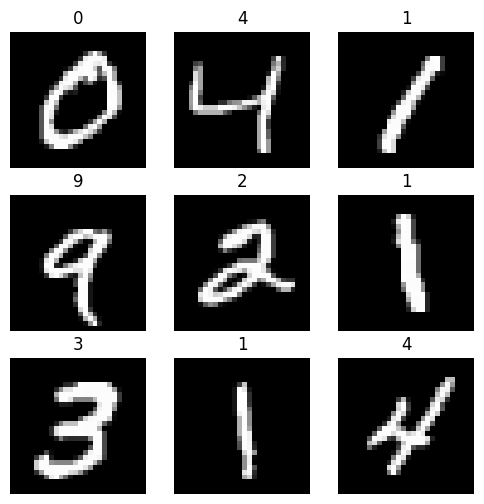

In [ ]:
# Визуализация
figure = plt.figure(figsize=(6, 6))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    img, label = training_data[i]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
# Разделили данные на батчи
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)


In [ ]:
# Делаем нейронную сеть
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()
model.to('cuda')

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [ ]:
# Делаем функции для тренировки и проверки
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X = X.to('cuda')
        y = y.to('cuda')
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss /= num_batches
    correct /= size
    return train_loss, correct

def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to('cuda')
            y = y.to('cuda')
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct


In [ ]:
learning_rate = 0.03
epochs = 5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_res = train_loop(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_res[0])
    train_accuracies.append(train_res[1])
    test_res = test_loop(test_dataloader, model, loss_fn)
    test_losses.append(test_res[0])
    test_accuracies.append(test_res[1])


print("Done!")

Epoch 1
-------------------------------
loss: 2.307693  [   64/60000]
loss: 2.045524  [ 6464/60000]
loss: 1.361120  [12864/60000]
loss: 0.732163  [19264/60000]
loss: 0.539744  [25664/60000]
loss: 0.455670  [32064/60000]
loss: 0.362519  [38464/60000]
loss: 0.475428  [44864/60000]
loss: 0.472763  [51264/60000]
loss: 0.434244  [57664/60000]
Test Error: 
 Accuracy: 89.2%, Avg loss: 0.364164 

Epoch 2
-------------------------------
loss: 0.334019  [   64/60000]
loss: 0.276739  [ 6464/60000]
loss: 0.249536  [12864/60000]
loss: 0.363756  [19264/60000]
loss: 0.263412  [25664/60000]
loss: 0.325240  [32064/60000]
loss: 0.211750  [38464/60000]
loss: 0.363924  [44864/60000]
loss: 0.339707  [51264/60000]
loss: 0.355155  [57664/60000]
Test Error: 
 Accuracy: 91.7%, Avg loss: 0.283012 

Epoch 3
-------------------------------
loss: 0.199904  [   64/60000]
loss: 0.245800  [ 6464/60000]
loss: 0.171770  [12864/60000]
loss: 0.338075  [19264/60000]
loss: 0.202734  [25664/60000]
loss: 0.287470  [32064/600

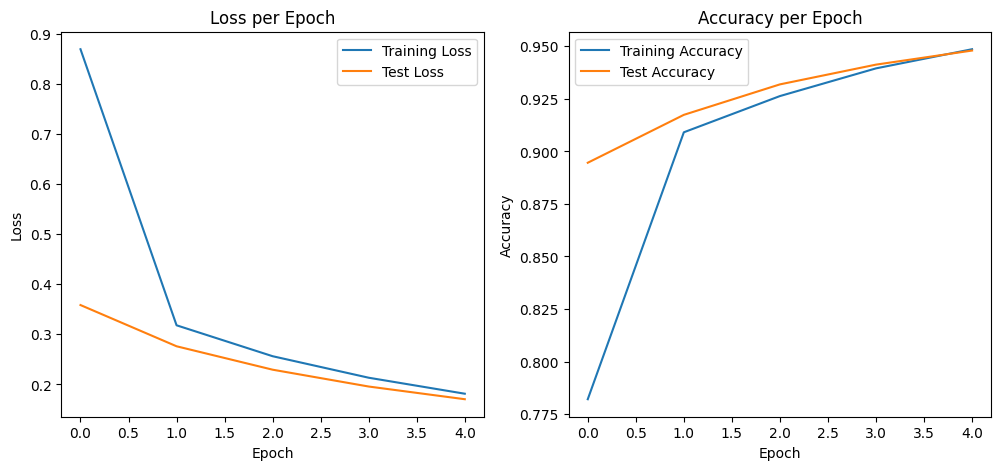

In [ ]:
# Визуализация потерь и точности
plt.figure(figsize=(12, 5))

# График функции потерь
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.plot(range(epochs), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracies, label='Training Accuracy')
plt.plot(range(epochs), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.show()

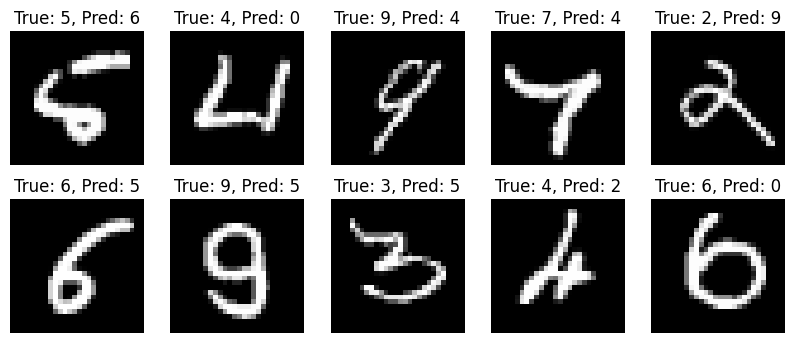

In [ ]:
# Выводим некорректные изображения
def display_incorrect_images(images, true_labels, pred_labels):
    plt.figure(figsize=(10, 4))
    for i in range(min(10, len(images))):  # Отобразить максимум 10 изображений
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"True: {true_labels[i]}, Pred: {pred_labels[i]}")
        plt.axis('off')
    plt.show()



incorrect_images = []  # Для хранения неверно классифицированных изображений
incorrect_labels = []  # Для хранения правильных меток
incorrect_preds = []  # Для хранения предсказанных меток
with torch.no_grad():
  for X, y in test_data:
      pred = model(X)
      if pred.argmax(1) != y:
        incorrect_images.append(X)
        incorrect_labels.append(y)
        incorrect_preds.append(pred.argmax(1).item())

display_incorrect_images(incorrect_images, incorrect_labels, incorrect_preds)

# Часть 2

In [ ]:
'''# Импорт датасета
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Инициализация набора данных.

        :param root_dir: Путь к корневому каталогу с данными
        :param transform: Преобразования, которые нужно применить к изображениям
        """
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.image_paths = []
        self.labels = []

        # Сбор всех изображений и соответствующих меток
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)r
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    if img_name.endswith(('.png', '.jpg', '.jpeg')):  # Фильтруем ненужные файлы
                        self.image_paths.append(img_path)
                        self.labels.append(label)

    def __len__(self):
        """Возвращает общее количество изображений в наборе данных."""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Получает изображение и его метку по индексу.

        :param idx: Индекс изображения
        :return: Кортеж (изображение, метка)
        """
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        print(image)  # Преобразуем в RGB на случай, если есть одноканальные изображения
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


data = CustomDataset(
    root_dir='/content/drive/MyDrive/Data/emotions',
    transform=ToTensor()
)

for X, y in data:
  print(X.shape)'''

# Импорт и нормализация
training_data = datasets.EMNIST(
    root="data",
    split='letters',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.EMNIST(
    root="data",
    split='letters',
    train=False,
    download=True,
    transform=ToTensor()
)

print(len(training_data))

124800


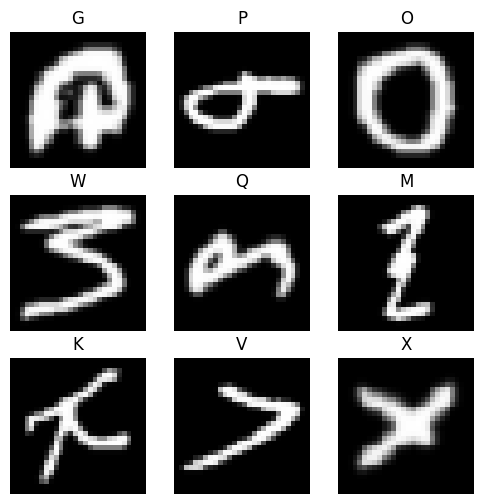

In [ ]:
# Визуализация
figure = plt.figure(figsize=(6, 6))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    img, label = training_data[i]
    figure.add_subplot(rows, cols, i)
    plt.title(chr(label + 64))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

In [ ]:
# Разделили данные на батчи
batch_size = 100
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [ ]:
# Делаем нейронную сеть
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.Tanh(),
            nn.Dropout(p=0.5),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(64, 26),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()
model.to('cuda')

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=64, out_features=27, bias=True)
  )
)

In [ ]:
learning_rate = 0.001
epochs = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_res = train_loop(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_res[0])
    train_accuracies.append(train_res[1])
    test_res = test_loop(test_dataloader, model, loss_fn)
    test_losses.append(test_res[0])
    test_accuracies.append(test_res[1])


print("Done!")

Epoch 1
-------------------------------
loss: 3.329047  [  100/124800]
loss: 2.243050  [10100/124800]
loss: 1.816739  [20100/124800]
loss: 1.486861  [30100/124800]
loss: 1.502298  [40100/124800]
loss: 1.476175  [50100/124800]
loss: 1.625046  [60100/124800]
loss: 1.258377  [70100/124800]
loss: 1.415310  [80100/124800]
loss: 1.197680  [90100/124800]
loss: 1.591927  [100100/124800]
loss: 1.383826  [110100/124800]
loss: 1.414616  [120100/124800]
Test Error: 
 Accuracy: 76.1%, Avg loss: 0.812619 

Epoch 2
-------------------------------
loss: 1.306182  [  100/124800]
loss: 1.300095  [10100/124800]
loss: 1.093721  [20100/124800]
loss: 0.894395  [30100/124800]
loss: 1.039651  [40100/124800]
loss: 1.283959  [50100/124800]
loss: 1.305647  [60100/124800]
loss: 0.993850  [70100/124800]
loss: 1.142475  [80100/124800]
loss: 1.108754  [90100/124800]
loss: 1.335119  [100100/124800]
loss: 1.075875  [110100/124800]
loss: 1.204593  [120100/124800]
Test Error: 
 Accuracy: 80.5%, Avg loss: 0.654935 

Epoc

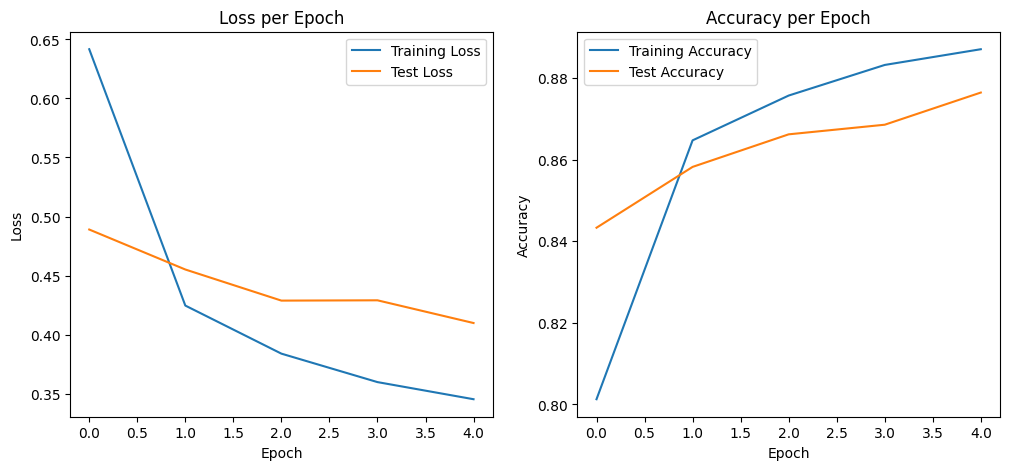

In [ ]:
# Визуализация потерь и точности
plt.figure(figsize=(12, 5))

# График функции потерь
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.plot(range(epochs), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracies, label='Training Accuracy')
plt.plot(range(epochs), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.show()

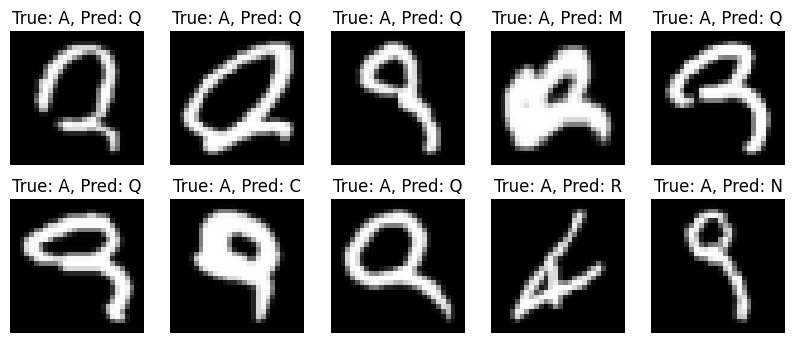

In [ ]:
# Выводим некорректные изображения
def display_incorrect_images(images, true_labels, pred_labels):
    plt.figure(figsize=(10, 4))
    for i in range(min(10, len(images))):  # Отобразить максимум 10 изображений
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"True: {chr(true_labels[i] + 64)}, Pred: {chr(pred_labels[i]+64)}")
        plt.axis('off')
    plt.show()



incorrect_images = []  # Для хранения неверно классифицированных изображений
incorrect_labels = []  # Для хранения правильных меток
incorrect_preds = []  # Для хранения предсказанных меток
with torch.no_grad():
  for X, y in test_data:
      pred = model(X)
      if pred.argmax(1) != y:
        incorrect_images.append(X)
        incorrect_labels.append(y)
        incorrect_preds.append(pred.argmax(1).item())

display_incorrect_images(incorrect_images, incorrect_labels, incorrect_preds)